# Tidal Heating and Torque versus Semi-major Axis
An example of using TidalPy functions


In [1]:
# Setup Jupyter environment and load in useful packages 
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import G

In [2]:
# Delete me!
try:
    import TidalPy
except ModuleNotFoundError:
    import sys, os
    cwd = os.getcwd()
    tpy = os.path.join(cwd, os.pardir)
    if tpy not in sys.path:
        sys.path.append(tpy)

In [3]:
# Import TidalPy 
from TidalPy.constants import mass_solar, mass_earth, radius_earth
from TidalPy.utilities.conversions import days2rads, m2Au, Au2m, orbital_motion2semi_a, semi_a2orbital_motion
from TidalPy.rheology import effective_rigidity, complex_love, find_complex_compliance, complex_compliances,\
    rheology_styles
from TidalPy.orbit import nsr_modes, spin_sync_modes

In [4]:
# Star and Planet Properties
star_mass = mass_solar
planet_mass = mass_earth
planet_radius = radius_earth
bulk_density = planet_mass / ((4/3) * np.pi * planet_radius**3)
surface_gravity = G * planet_mass / planet_radius**2

# Material Properties
shear = 5.0e10
viscosity = 1.0e20
compliance = shear**-1

# Self-Gravity
effe_rigid = effective_rigidity(shear, surface_gravity, planet_radius, bulk_density)

In [5]:
# Rheological Constants
zeta = 1.0
alpha = 0.3
fixed_q = 10
fixed_q2 = 1000
beta = planet_radius * bulk_density * surface_gravity
moi = (2. / 5.) * planet_mass * planet_radius**2

# Get Rheological Functions by Searching...
# Tell it the layer type
find_complex_compliance.default_key = 'rock'
maxwell_comp, _, _ = find_complex_compliance('Maxwell')
# or by direct import...
andrade_comp = complex_compliances.andrade
fixed_q_comp = complex_compliances.fixed_q

# Create Helper Functions
maxwell_neg_imk_func = \
    lambda tidal_mode: -np.imag(complex_love(maxwell_comp(compliance, viscosity, tidal_mode),
                                shear, effe_rigid))
andrade_neg_imk_func = \
    lambda tidal_mode: -np.imag(complex_love(andrade_comp(compliance, viscosity, tidal_mode, alpha, zeta),
                                shear, effe_rigid))
fixed_q_neg_imk_func = \
    lambda tidal_mode: -np.imag(complex_love(fixed_q_comp(compliance, viscosity, tidal_mode, fixed_q, beta),
                                shear, effe_rigid))
fixed_q2_neg_imk_func = \
    lambda tidal_mode: -np.imag(complex_love(fixed_q_comp(compliance, viscosity, tidal_mode, fixed_q2, beta),
                                shear, effe_rigid))

neg_imk_funcs = {
    'Maxwell': (maxwell_neg_imk_func, '-g'),
    'Andrade': (andrade_neg_imk_func, '-b'),
    f'Fixed-Q, Q={fixed_q}': (fixed_q_neg_imk_func, '-y'),
    f'Fixed-Q, Q={fixed_q2}': (fixed_q2_neg_imk_func, '-c')
}

In [6]:
# Setup Domain of Study 
spin_frequency = days2rads(2.)
semi_major_axis_au = np.linspace(0.0001, .1, 1000)

# Make sure that the semi-major axis actually has the resonances
resonances = np.asarray([spin_frequency, 2.*spin_frequency, spin_frequency/2., (2/3)*spin_frequency, (3/2)*spin_frequency])
resonances = m2Au(orbital_motion2semi_a(resonances, star_mass, planet_mass))
semi_major_axis_au = np.concatenate((semi_major_axis_au, resonances))
semi_major_axis_au = np.sort(semi_major_axis_au)

# Conversions
semi_major_axis = Au2m(semi_major_axis_au)
orbital_frequency = semi_a2orbital_motion(semi_major_axis, star_mass, planet_mass)

# Spin-rate needs to be the same shape as orbital frequency
spin_frequency = days2rads(2.) * np.ones_like(orbital_frequency)
eccentricity = np.asarray([0.2])
inclination = np.asarray([np.deg2rad(5.)])
loc = np.abs(orbital_frequency - days2rads(2.0)).argmin()

In [7]:
# Find Regular Tidal Modes (only one mode = orbital motion)
tidal_modes, tidal_freqs, heating_coefficients, torque_coefficients = \
    spin_sync_modes(orbital_frequency, eccentricity, inclination)
freq_sync = tidal_freqs[0]
heating_coeff_sync = heating_coefficients[0]
torque_coeff_sync = torque_coefficients[0]

# Find NSR Tidal Modes
tidal_modes_NSR, tidal_freqs_NSR, heating_coefficients_NSR, torque_coefficients_NSR = \
    nsr_modes(orbital_frequency, spin_frequency, eccentricity, inclination)

In [8]:
# Calculate Tidal Heating and Torque and Plot
tidal_susceptibility = (3. / 2.) * G * star_mass**2 * planet_radius**5 / semi_major_axis**6
tidal_heating_byrheo = dict()
tidal_torque_real_byrheo = dict()
tidal_torque_byrheo = dict()
tidal_torque_neg_byrheo = dict()

for rheo_name, (imk_func, style) in neg_imk_funcs.items():
    
    heating_scaled_imk = \
        sum([imk_func(freq) * heat_coeff for freq, heat_coeff in zip(tidal_freqs_NSR, heating_coefficients_NSR)])
    tidal_heating = tidal_susceptibility * heating_scaled_imk
    torque_scaled_imk = \
        sum([imk_func(freq) * torque_coeff for freq, torque_coeff in zip(tidal_freqs_NSR, torque_coefficients_NSR)])
    tidal_torque = tidal_susceptibility * torque_scaled_imk
    tidal_torque_real_byrheo[rheo_name] = np.copy(tidal_torque)
    
    # Make a negative torque that we will plot in a different color (due to log scaling)
    tidal_torque_neg = np.zeros_like(tidal_torque)
    tidal_torque_neg[tidal_torque < 0.] = -tidal_torque[tidal_torque < 0.]
    tidal_torque[tidal_torque <= 0.] = np.nan
    tidal_torque_neg[tidal_torque_neg <= 0.] = np.nan
    
    # Store Values
    tidal_heating_byrheo[rheo_name] = tidal_heating
    tidal_torque_byrheo[rheo_name] = tidal_torque
    tidal_torque_neg_byrheo[rheo_name] = tidal_torque_neg

### Plot Set 1

Lighter colors on the tidal torque plot indicate a negative torque.


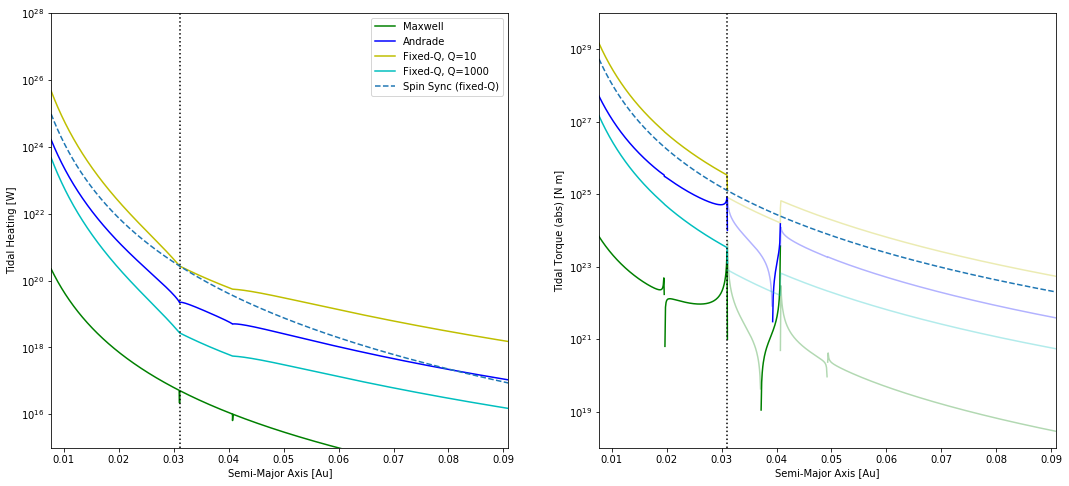

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18,8))

# x-limits
xlim1 = m2Au(orbital_motion2semi_a(days2rads(.25), star_mass, planet_mass))
xlim2 = m2Au(orbital_motion2semi_a(days2rads(10.), star_mass, planet_mass))
xlim = (xlim1, xlim2)

for rheo_name, (imk_func, style) in neg_imk_funcs.items():
    # Get Data
    tidal_heating = tidal_heating_byrheo[rheo_name]
    tidal_torque = tidal_torque_byrheo[rheo_name]
    tidal_torque_neg = tidal_torque_neg_byrheo[rheo_name]
    
    # Get consistent rheology style information
    # rheo_style = rheology_styles[rheo_name.lower()]
    
    # Heating Plot
    axes[0].plot(semi_major_axis_au, tidal_heating, style, label=rheo_name)
    
    # Torque Plot
    axes[1].plot(semi_major_axis_au, tidal_torque, style, label=rheo_name)
    axes[1].plot(semi_major_axis_au, tidal_torque_neg, style, label=rheo_name, alpha=0.3)
    
# Add the non-NSR result (just use a fixed-Q model)
imk_sync = fixed_q_neg_imk_func(freq_sync)
heating_sync = tidal_susceptibility * imk_sync * heating_coeff_sync
torque_sync = tidal_susceptibility * imk_sync * torque_coeff_sync
axes[0].plot(semi_major_axis_au, heating_sync, label='Spin Sync (fixed-Q)', ls='--')
axes[1].plot(semi_major_axis_au, torque_sync, label='Spin Sync (fixed-Q)', ls='--')

# Add spin-sync location
spin_sync_semi_a_au = m2Au(orbital_motion2semi_a(spin_frequency[0], star_mass, planet_mass))
axes[0].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
axes[1].axvline(x=spin_sync_semi_a_au, c='k', ls=':')

# Other plot styles
axes[0].set_xlabel('Semi-Major Axis [Au]')
axes[0].set_ylabel('Tidal Heating [W]')
axes[0].set_yscale('log')
axes[1].set_xlabel('Semi-Major Axis [Au]')
axes[1].set_ylabel('Tidal Torque (abs) [N m]')
axes[1].set_yscale('log')
axes[0].set_xlim(xlim)
axes[1].set_xlim(xlim)
axes[0].set_ylim((1e15, 1e28))
axes[1].set_ylim((1e18, 1e30))
axes[0].legend(loc='best')

print('Lighter colors on the tidal torque plot indicate a negative torque.')
plt.show()

### Plot Set 2 (semi-major axis ^7.5)

Lighter colors on the tidal torque plot indicate a negative torque.


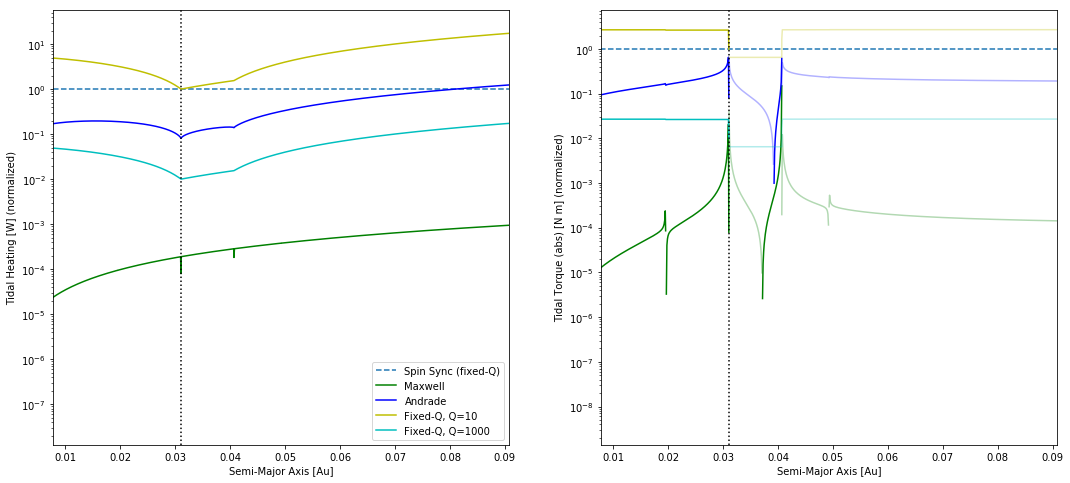

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(18,8))

# Add the non-NSR result (just use a fixed-Q model)
imk_sync = fixed_q_neg_imk_func(freq_sync)
heating_sync = tidal_susceptibility * imk_sync * heating_coeff_sync
torque_sync = tidal_susceptibility * imk_sync * torque_coeff_sync
axes[0].plot(semi_major_axis_au, heating_sync/heating_sync, label='Spin Sync (fixed-Q)', ls='--')
axes[1].plot(semi_major_axis_au, torque_sync/torque_sync, label='Spin Sync (fixed-Q)', ls='--')

for rheo_name, (imk_func, style) in neg_imk_funcs.items():
    # Get Data
    tidal_heating = tidal_heating_byrheo[rheo_name]
    tidal_torque = tidal_torque_byrheo[rheo_name]
    tidal_torque_neg = tidal_torque_neg_byrheo[rheo_name]
    
    # Get consistent rheology style information
    # rheo_style = rheology_styles[rheo_name.lower()]
    
    # Heating Plot
    axes[0].plot(semi_major_axis_au, tidal_heating/heating_sync, style, label=rheo_name)
    
    # Torque Plot
    axes[1].plot(semi_major_axis_au, tidal_torque/torque_sync, style, label=rheo_name)
    axes[1].plot(semi_major_axis_au, tidal_torque_neg/torque_sync, style, alpha=0.3)

# Add spin-sync location
spin_sync_semi_a_au = m2Au(orbital_motion2semi_a(spin_frequency[0], star_mass, planet_mass))
axes[0].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
axes[1].axvline(x=spin_sync_semi_a_au, c='k', ls=':')

# Other plot styles
axes[0].set_xlabel('Semi-Major Axis [Au]')
axes[0].set_ylabel('Tidal Heating [W] (normalized)')
axes[0].set_yscale('log')
axes[1].set_xlabel('Semi-Major Axis [Au]')
axes[1].set_ylabel('Tidal Torque (abs) [N m] (normalized)')
axes[1].set_yscale('log')
axes[0].set_xlim(xlim)
axes[1].set_xlim(xlim)
axes[0].legend(loc='best')

print('Lighter colors on the tidal torque plot indicate a negative torque.')
plt.show()

## Orbital Evolution

In [11]:
from TidalPy.dynamics.single_dissipation import spin_rate_derivative, semi_major_axis_derivative, eccentricity_derivative
from TidalPy.utilities.conversions import sec2myr

In [12]:
spin_rate_timescale_byrheo = dict()
semi_major_axis_derivative_byrheo = dict()
eccentricity_timescale_byrheo = dict()

for rheo_name, (imk_func, style) in neg_imk_funcs.items():
    # Get Data
    tidal_heating = tidal_heating_byrheo[rheo_name]
    tidal_torque = tidal_torque_real_byrheo[rheo_name]
    
    # Calculate Derivatives
    da_dt = semi_major_axis_derivative(semi_major_axis, star_mass, planet_mass, spin_frequency, tidal_torque, tidal_heating)
    de_dt = eccentricity_derivative(semi_major_axis, eccentricity, star_mass, planet_mass, spin_frequency, tidal_torque, tidal_heating)
    dO_dt = spin_rate_derivative(tidal_torque, moi)
    
    # Calculate Timescales
    tau_e = sec2myr(-eccentricity / de_dt)
    tau_O = sec2myr(-abs(spin_frequency - orbital_frequency) / dO_dt)
    
    # Convert [m s-1] to [au myr-1]
    da_dt = m2Au(da_dt) * 3.154e13
    
    # Store
    spin_rate_timescale_byrheo[rheo_name] = tau_O
    semi_major_axis_derivative_byrheo[rheo_name] = da_dt
    eccentricity_timescale_byrheo[rheo_name] = tau_e 


Lighter colors on the tidal torque plot indicate a negative torque.


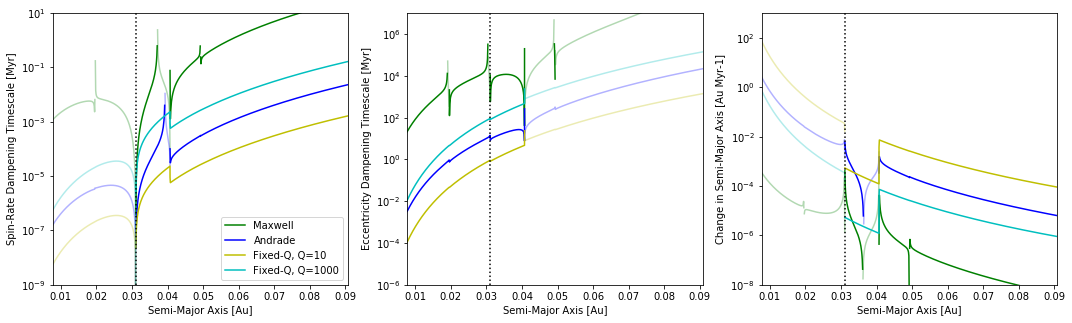

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

for rheo_name, (imk_func, style) in neg_imk_funcs.items():
    # Get Data
    tau_O = spin_rate_timescale_byrheo[rheo_name]
    da_dt = semi_major_axis_derivative_byrheo[rheo_name]
    tau_e = eccentricity_timescale_byrheo[rheo_name]
    
    # Flip negatives
    tau_O_neg = np.zeros_like(tau_O)
    tau_O_neg[tau_O < 0.] = -tau_O[tau_O < 0.]
    tau_O_neg[tau_O_neg <= 0.] = np.nan
    tau_O[tau_O <= 0.] = np.nan
    
    da_dt_neg = np.zeros_like(da_dt)
    da_dt_neg[da_dt < 0.] = -da_dt[da_dt < 0.]
    da_dt_neg[da_dt_neg <= 0.] = np.nan
    da_dt[da_dt <= 0.] = np.nan
    
    tau_e_neg = np.zeros_like(tau_e)
    tau_e_neg[tau_e < 0.] = -tau_e[tau_e < 0.]
    tau_e_neg[tau_e_neg <= 0.] = np.nan
    tau_e[tau_e <= 0.] = np.nan
    
    # Spin Timescales
    axes[0].plot(semi_major_axis_au, tau_O, style, label=rheo_name)
    axes[0].plot(semi_major_axis_au, tau_O_neg, style, alpha=0.3)
    
    # Eccentricity Timescales
    axes[1].plot(semi_major_axis_au, tau_e, style, label=rheo_name)
    axes[1].plot(semi_major_axis_au, tau_e_neg, style,alpha=0.3)
    
    # Semi-major Axis
    axes[2].plot(semi_major_axis_au, da_dt, style, label=rheo_name)
    axes[2].plot(semi_major_axis_au, da_dt_neg, style,alpha=0.3)

# Add spin-sync location
spin_sync_semi_a_au = m2Au(orbital_motion2semi_a(spin_frequency[0], star_mass, planet_mass))
axes[0].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
axes[1].axvline(x=spin_sync_semi_a_au, c='k', ls=':')
axes[2].axvline(x=spin_sync_semi_a_au, c='k', ls=':')

# Other plot styles
axes[0].set_xlabel('Semi-Major Axis [Au]')
axes[0].set_ylabel('Spin-Rate Dampening Timescale [Myr]')
axes[0].set_yscale('log')
axes[1].set_xlabel('Semi-Major Axis [Au]')
axes[1].set_ylabel('Eccentricity Dampening Timescale [Myr]')
axes[1].set_yscale('log')
axes[2].set_xlabel('Semi-Major Axis [Au]')
axes[2].set_ylabel('Change in Semi-Major Axis [Au Myr-1]')
axes[2].set_yscale('log')
axes[0].set_xlim(xlim)
axes[1].set_xlim(xlim)
axes[2].set_xlim(xlim)
axes[0].set_ylim((1e-9, 1e1))
axes[1].set_ylim((1e-6, 1e7))
axes[2].set_ylim((1e-8, 1e3))
axes[0].legend(loc='best')

print('Lighter colors on the tidal torque plot indicate a negative torque.')
plt.show()